================================= Author: Arman Javan Sekhavat =================================


In this notebook, a test trajectory is generated and the manipulator's 
motion along this trajectory is simulated. For each time step of the 
simulation, some kinematic and dynamic characteristics of the robot's
motion are predicted by manually implementing the related algorithms.
To verify the predictions, they are compared to outputs of the MuJoCo 
physics engine. Notice that you might experience a delay at the beginning
of the simulation, which is due to JIT-compilation of the inverse dynamics 
code.

In [1]:
# -------------------------  Standard modules
import mujoco
import numpy as np
from mujoco import viewer
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [2]:
# -------------------------  Custom modules
import ForwardKinematics
import InverseDynamics
import TrajectoryGeneration

In [3]:
# -------------------------  Loading the model
m = mujoco.MjModel.from_xml_path("Robotic_Arm_DirectDrive.xml")
d = mujoco.MjData(m)

In [6]:
mujoco.mj_resetData(m, d) # Resets simulation state before each execution of this cell



#---------------------------- Containers to store the simulation results and the predictions ----------------------------

Q = [] # Joint positions
Q_dot = [] # Joint velocities


T = [] # End-effector's posture (homogeneous transformation matrix)
Quat = [] # End-effector's orientation (quaternion)
RotVec = [] # End-effector's orientation (angle-axis representation)
V = [] # End-effector's absolute velocities (linear and angular)
tau = [] # Actual joint torques
KE = [] # Actual kinetic energy


T_pred = []
Quat_pred = []
RotVec_pred = []
V_pred = []
Jacobian_det = [] # Determinant of the basic Jacobian matrix
tau_pred_NE = [] # Predicted joint torques (Newton-Euler algorithm)
tau_pred_LA = [] # Predicted joint torques (Lagrange formulation)
KE_pred = [] # Predicted kinetic energy




#---------------------------- Generating a test trajectory which passes through the following ---------------------------
#---------------------------- points in the configuration space (via points)                  ---------------------------

q_list = np.array([[0.0, +np.pi/2, 0.0, -np.pi/2, 0.0, 0.03],
                    [-0.03, 0.424, 1.91, -2.94, 0.095, 0.03],
                    [0.157, 0.393, 1.44, -2.58, 0.095, 0.03],
                    [0.251, 0.314, 1.24, -2.33, 0.095, 0.06],
                    [0.534, 0.456, 1.01, -2.4, 0.251, 0.116],
                    [0.817, 0.676, 0.063, -1.73, 0.723, 0.124],
                    [1.85, 1.81, -1.26, -2.58, -0.66, 0.05]])


dt_list = np.array([2.0, 1.0, 1.0, 2.0, 2.0, 2.0]) # Duration for each path segment
a = TrajectoryGeneration.Quintic(q_list, dt_list) # Coefficients of the quintic path generator
duration = np.sum(dt_list) # Seconds


n_steps = int(duration/m.opt.timestep)
t = np.linspace(start = 0.0, stop = duration, num = n_steps) # Simulation time
viewer_obj = mujoco.viewer.launch_passive(m, d) # Launching MuJoCo viewer GUI


# -------------------------  Simulation loop
for k in range(n_steps):

    sim_time = t[k]

    q, q_dot, q_ddot = TrajectoryGeneration.QuinticGenerator(a, dt_list, sim_time)

    d.qpos[0:6] = q
    d.qvel[0:6] = q_dot
    d.qacc[0:6] = q_ddot
    d.time = sim_time
    
    mujoco.mj_inverse(m, d) # Inverse dynamics
    viewer_obj.sync()


    # ------------------------- Recording the simulation results
    Q.append(np.array(q))
    Q_dot.append(np.reshape(q_dot, shape = (6, 1)))

    tau.append(np.array(d.qfrc_inverse[0:6]))
    tau_pred_NE.append(InverseDynamics.Newton_Euler_jit(q, q_dot, q_ddot))
    tau_pred_LA.append(InverseDynamics.Lagrange_jit(q, q_dot, q_ddot))

    KE.append(d.sensordata[-2])
    KE_pred.append(InverseDynamics.Kinetic_Energy_jit(q, q_dot))


    x_axis = np.reshape(np.array(d.sensordata[7:10]) , shape = (3, 1))
    y_axis = np.reshape(np.array(d.sensordata[10:13]), shape = (3, 1))
    z_axis = np.reshape(np.array(d.sensordata[13:16]), shape = (3, 1))
    P = np.reshape(np.array(d.sensordata[0:3]), shape = (3, 1))
    temp = np.hstack((x_axis, y_axis, z_axis, P))
    T.append( np.vstack((temp, np.array([[0.0, 0.0, 0.0, 1.0]]))) )

    Quat.append(np.reshape(np.array(d.sensordata[3:7]), shape = (4, 1)))
    
    r = Rotation.from_matrix(temp[0:3, 0:3])
    RotVec.append(r.as_rotvec())

    V.append(np.reshape(np.array(d.sensordata[16:22]), shape = (6, 1)))


viewer_obj.close()

In [ ]:
# -------------------------  Prediction

for q, q_dot in zip(Q, Q_dot):
    T_pred.append(ForwardKinematics.Homogeneous(q))
    Quat_pred.append(ForwardKinematics.Quaternion(q))
    RotVec_pred.append(ForwardKinematics.AngleAxis(q))

    Jacobian = ForwardKinematics.Jacobian_jit(q)
    V_pred.append(Jacobian@q_dot)
    Jacobian_det.append(np.linalg.det(Jacobian))

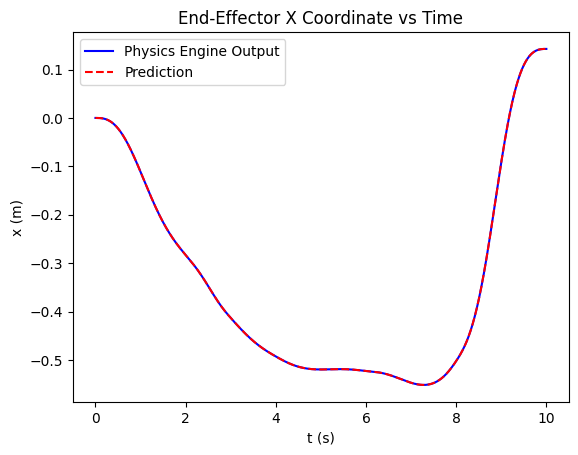

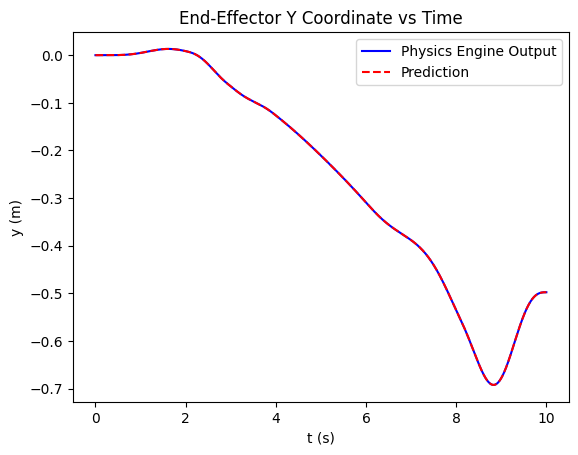

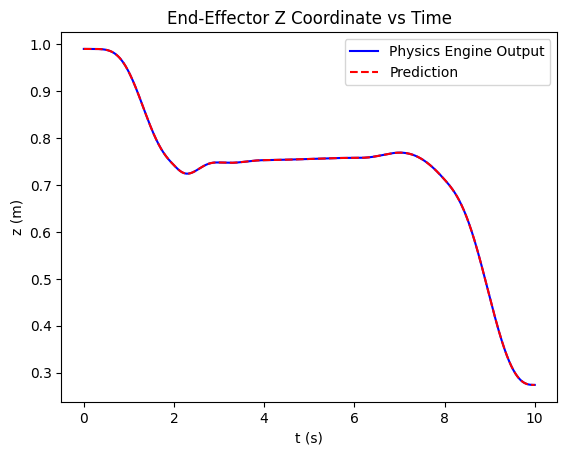

In [19]:
T = np.array(T)
T_pred = np.array(T_pred)

plt.figure()
plt.plot(t, T[:, 0, 3], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, T_pred[:, 0, 3], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("x (m)")
plt.title("End-Effector X Coordinate vs Time")
plt.show()

plt.figure()
plt.plot(t, T[:, 1, 3], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, T_pred[:, 1, 3], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("y (m)")
plt.title("End-Effector Y Coordinate vs Time")
plt.show()

plt.figure()
plt.plot(t, T[:, 2, 3], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, T_pred[:, 2, 3], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("z (m)")
plt.title("End-Effector Z Coordinate vs Time")
plt.show()

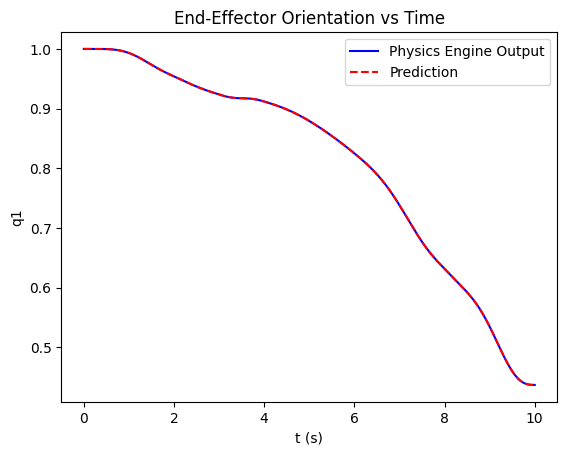

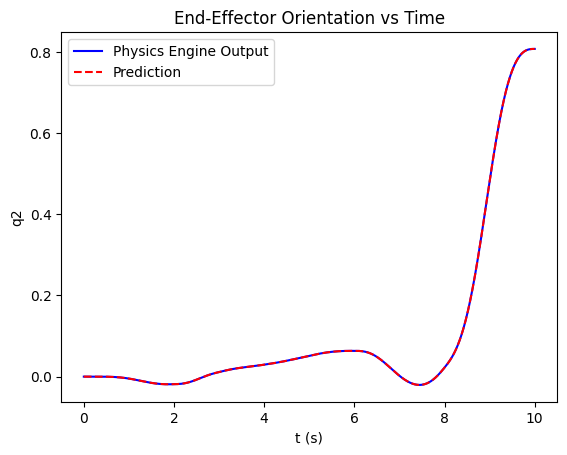

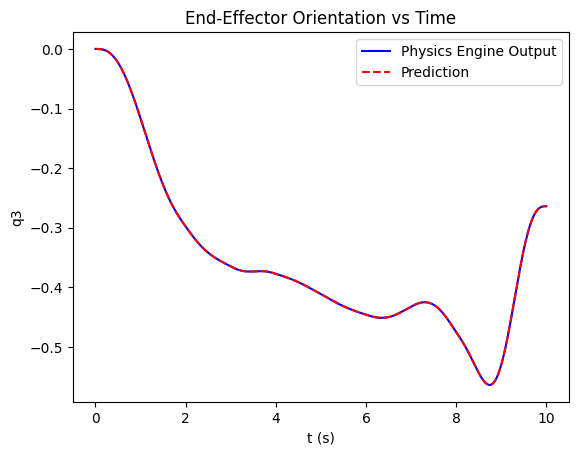

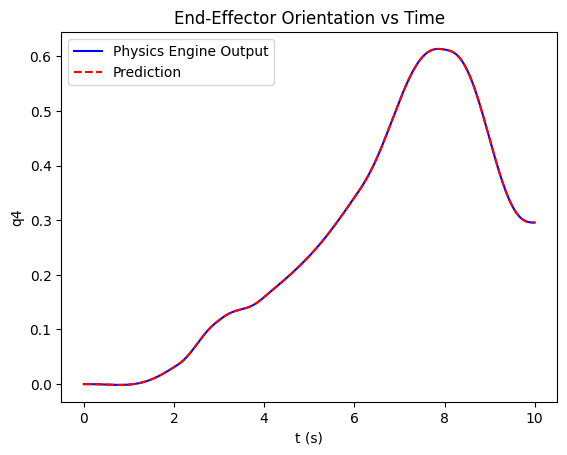

In [20]:
Quat = np.array(Quat)
Quat_pred = np.array(Quat_pred)


plt.figure()
plt.plot(t, Quat[:, 0], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, Quat_pred[:, 0], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("q1")
plt.title("End-Effector Orientation vs Time")
plt.show()

plt.figure()
plt.plot(t, Quat[:, 1], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, Quat_pred[:, 1], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("q2")
plt.title("End-Effector Orientation vs Time")
plt.show()

plt.figure()
plt.plot(t, Quat[:, 2], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, Quat_pred[:, 2], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("q3")
plt.title("End-Effector Orientation vs Time")
plt.show()

plt.figure()
plt.plot(t, Quat[:, 3], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, Quat_pred[:, 3], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("q4")
plt.title("End-Effector Orientation vs Time")
plt.show()

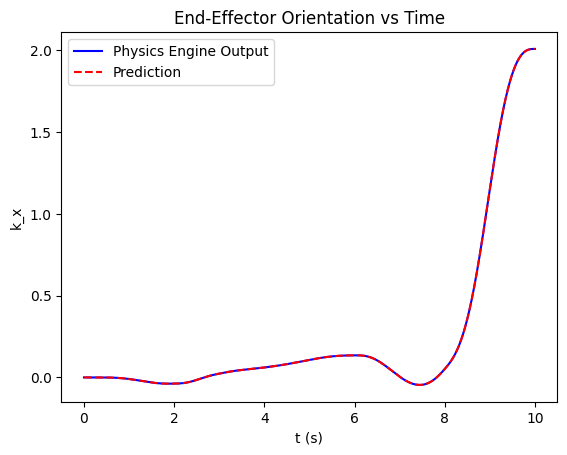

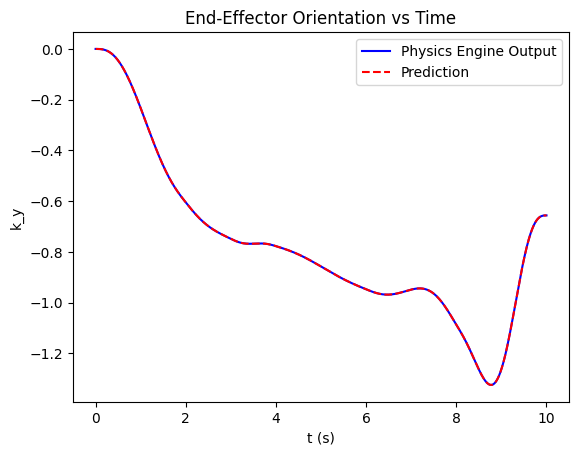

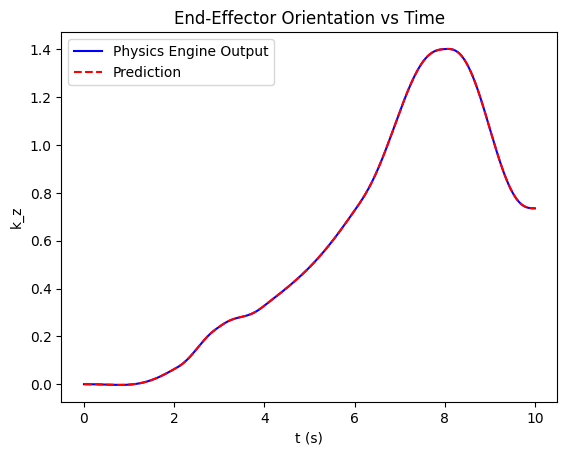

In [21]:
RotVec = np.array(RotVec)
RotVec_pred = np.array(RotVec_pred)

plt.figure()
plt.plot(t, RotVec[:, 0], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, RotVec_pred[:, 0], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("k_x")
plt.title("End-Effector Orientation vs Time")
plt.show()

plt.figure()
plt.plot(t, RotVec[:, 1], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, RotVec_pred[:, 1], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("k_y")
plt.title("End-Effector Orientation vs Time")
plt.show()

plt.figure()
plt.plot(t, RotVec[:, 2], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, RotVec_pred[:, 2], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("k_z")
plt.title("End-Effector Orientation vs Time")
plt.show()

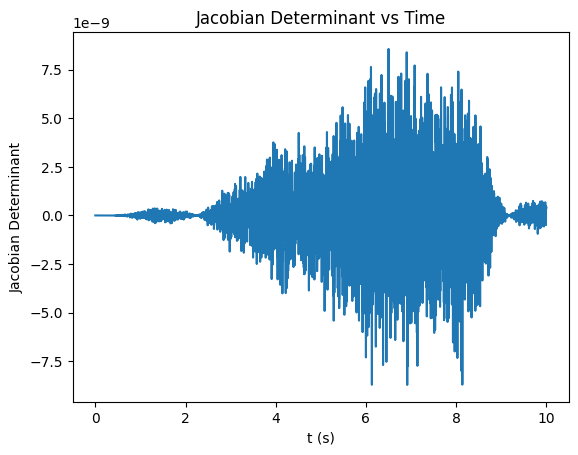

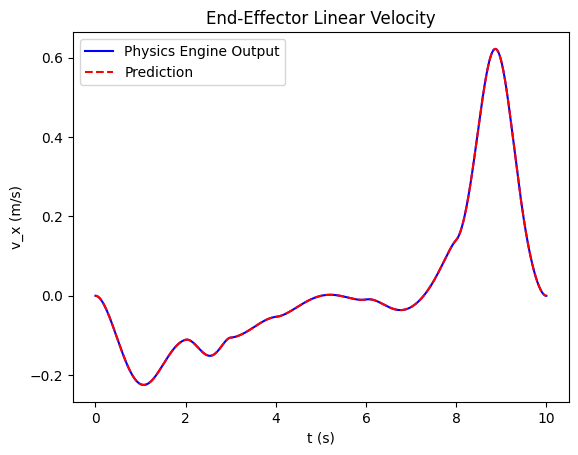

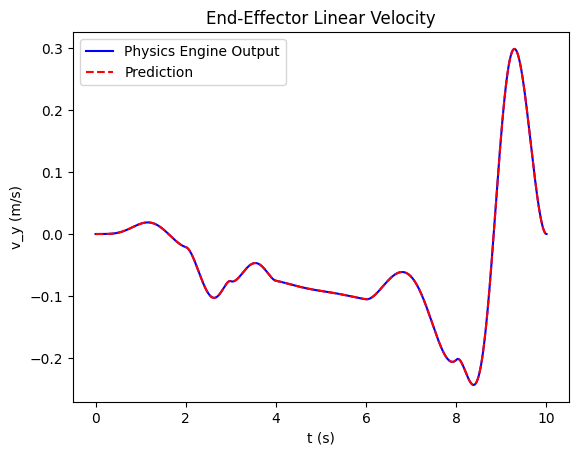

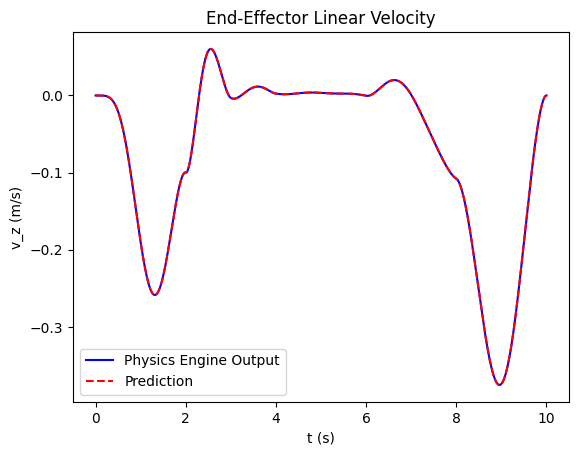

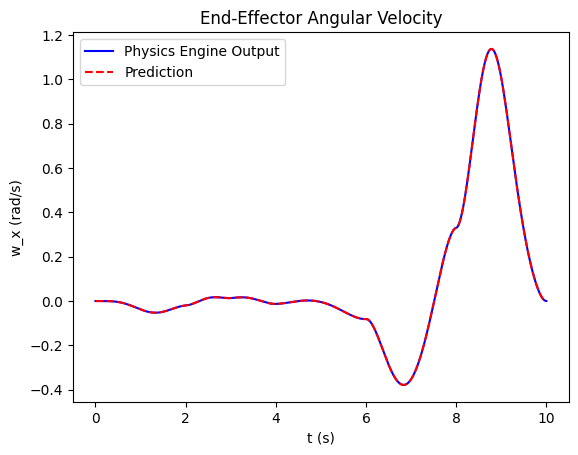

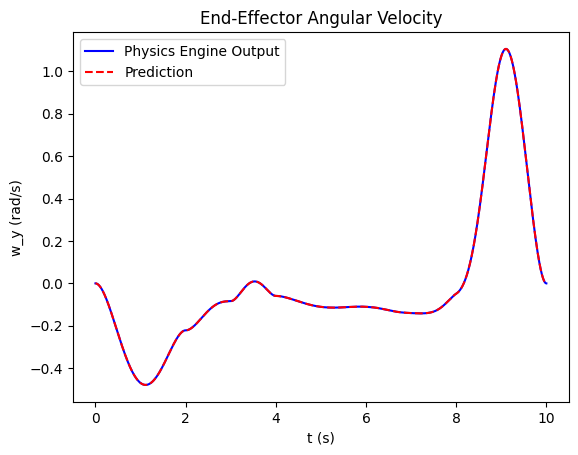

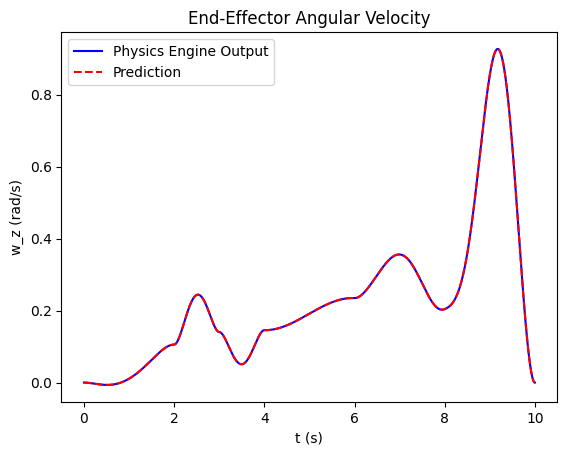

In [22]:
Jacobian_det = np.array(Jacobian_det)
V = np.array(V)
V_pred = np.array(V_pred)

plt.figure()
plt.plot(t, Jacobian_det)
plt.xlabel("t (s)")
plt.ylabel("Jacobian Determinant")
plt.title("Jacobian Determinant vs Time")
plt.show()


plt.figure()
plt.plot(t, V[:, 0], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, V_pred[:, 0], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("v_x (m/s)")
plt.title("End-Effector Linear Velocity")
plt.show()


plt.figure()
plt.plot(t, V[:, 1], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, V_pred[:, 1], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("v_y (m/s)")
plt.title("End-Effector Linear Velocity")
plt.show()


plt.figure()
plt.plot(t, V[:, 2], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, V_pred[:, 2], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("v_z (m/s)")
plt.title("End-Effector Linear Velocity")
plt.show()


plt.figure()
plt.plot(t, V[:, 3], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, V_pred[:, 3], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("w_x (rad/s)")
plt.title("End-Effector Angular Velocity")
plt.show()


plt.figure()
plt.plot(t, V[:, 4], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, V_pred[:, 4], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("w_y (rad/s)")
plt.title("End-Effector Angular Velocity")
plt.show()


plt.figure()
plt.plot(t, V[:, 5], label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, V_pred[:, 5], label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("w_z (rad/s)")
plt.title("End-Effector Angular Velocity")
plt.show()

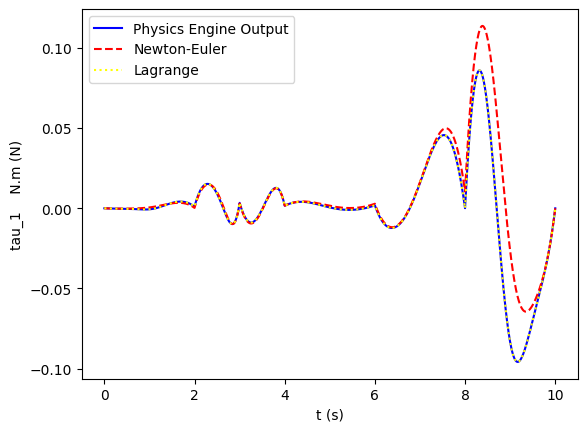

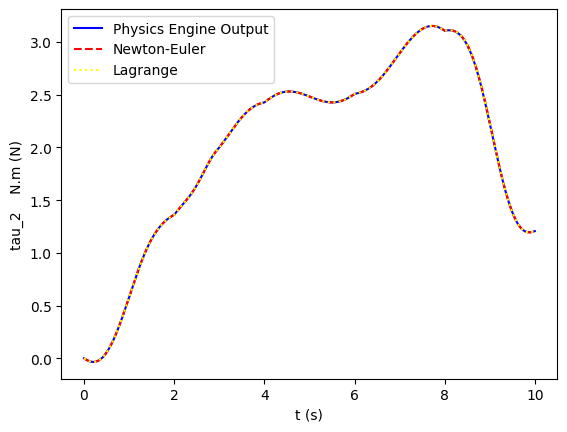

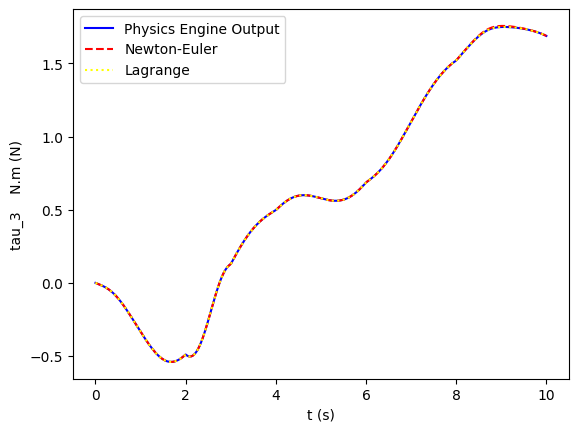

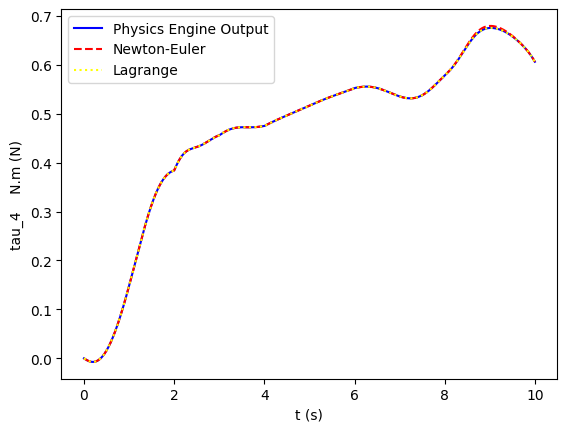

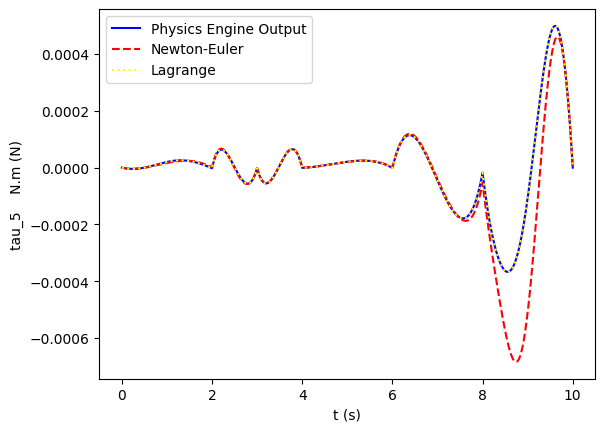

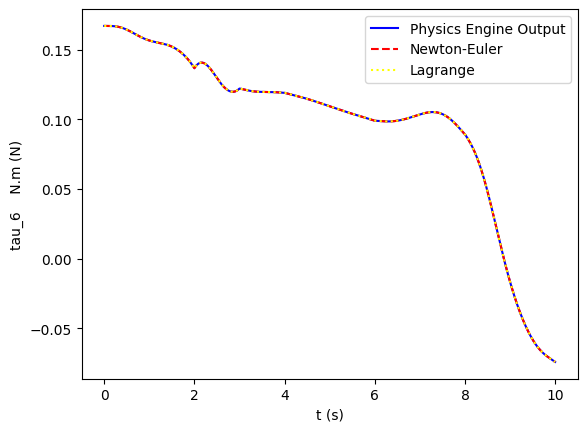

In [23]:
tau = np.array(tau)
tau_pred_NE = np.array(tau_pred_NE)
tau_pred_LA = np.array(tau_pred_LA)

for i in range(6):
    plt.figure()
    plt.plot(t, tau[:, i], label = "Physics Engine Output", linestyle = "solid", color = "blue")
    plt.plot(t, tau_pred_NE[:, i], label = "Newton-Euler", linestyle = "dashed", color = "red")
    plt.plot(t, tau_pred_LA[:, i], label = "Lagrange", linestyle = "dotted", color = "yellow")
    plt.legend()
    plt.xlabel("t (s)")
    plt.ylabel("tau_" + str(i+1) + "    N.m (N)")
    plt.show()

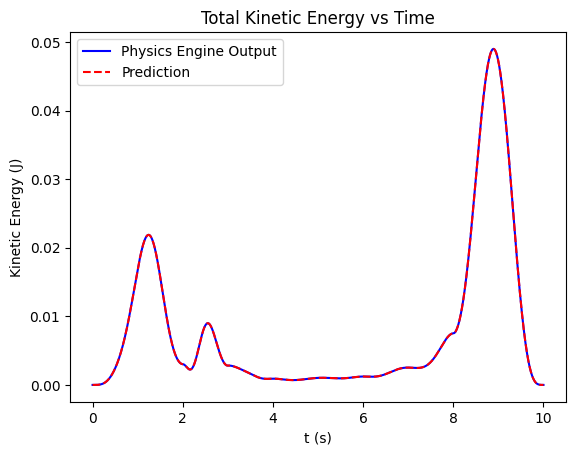

In [5]:
KE = np.array(KE)
KE_pred = np.array(KE_pred)

plt.figure()
plt.plot(t, KE, label = "Physics Engine Output", linestyle = "solid", color = "blue")
plt.plot(t, KE_pred, label = "Prediction", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("Kinetic Energy (J)")
plt.title("Total Kinetic Energy vs Time")
plt.show()